<a href="https://colab.research.google.com/github/caq05630/deep-learning-from-scratch-3/blob/master/Copy_of_Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization 

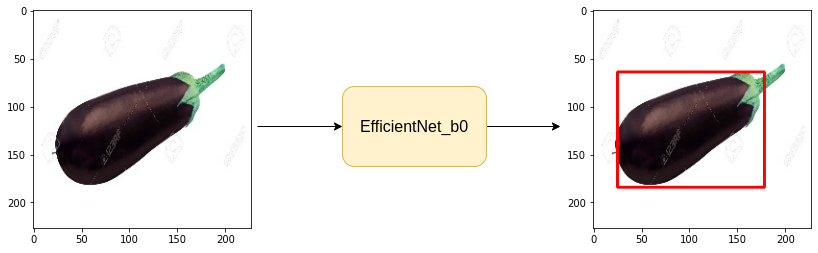

In [ ]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-fjzkzhc_
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-fjzkzhc_
  Resolved https://github.com/albumentations-team/albumentations to commit 2a1826d49c9442ae28cf33ddef658c8e24505cf8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=124568 sha256=fec930cd36e2aa20e083a79f6148f8e2b55d1d0820c19237f8b992fb148ea76d
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3777gp3/wheels/f3/4a/7f/67b055656bec4d4aaa8963cfc93678f6f2906b2d72054a1268
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 11.92 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE ='/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE=16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

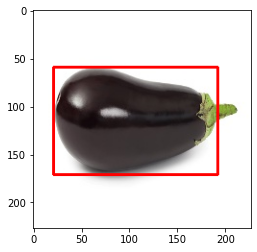

In [ ]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR +row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1,pt2, (255,0,0), 2)
plt.imshow(img)


In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['class_labels']) )

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['class_labels']) )


# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

    def __init__(self, df, augmentations= None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
        
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0 # permute   (h, w, c) - > ( c, h, w)
        bbox = torch.Tensor(bbox)
        return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(train_df, valid_augs)

In [ ]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")

Total examples in the trainset : 148
Total examples in the validset : 148


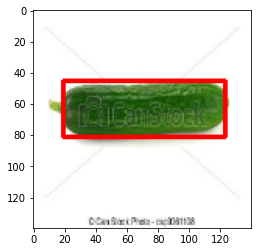

In [ ]:
img, bbox = trainset[20]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True )
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False )

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 10


In [ ]:
for images, bboxes in trainloader:
    break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):

    def __init__(self):
        super(ObjLocModel, self).__init__()
        self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

    def forward(self, images, gt_bboxes = None):
        bboxes = self.backbone(images)

        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        
        return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() # Dropout ON

    for data in tqdm(dataloader):

        images, gt_bboxes  = data
        images, gt_bboxes  = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len (dataloader)



In [ ]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()# Dropout OFF

    with torch.no_grad():
        for data in tqdm(dataloader):

            images, gt_bboxes  = data
            images, gt_bboxes  = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
        
            total_loss += loss.item()

    return total_loss / len (dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")

        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss
    
    print(f"Eopch : {i + 1} train loss: {train_loss} valid_loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 1 train loss: 5186.463232421875 valid_loss: 4075.71943359375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 2 train loss: 2028.4923583984375 valid_loss: 4444.47216796875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 3 train loss: 1267.6482482910155 valid_loss: 508.49611511230466


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 4 train loss: 748.809326171875 valid_loss: 260.2977691650391


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 5 train loss: 500.82544860839846 valid_loss: 227.182283782959


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 6 train loss: 368.7140869140625 valid_loss: 161.99254150390624


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 7 train loss: 269.043278503418 valid_loss: 114.97005500793458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 8 train loss: 181.08221435546875 valid_loss: 114.57697982788086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 9 train loss: 166.71481475830078 valid_loss: 96.57385897636414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 10 train loss: 133.49442367553712 valid_loss: 107.06797523498535


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 11 train loss: 108.27032089233398 valid_loss: 107.48015937805175


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 12 train loss: 131.45022163391113 valid_loss: 103.65904083251954


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 13 train loss: 112.66881561279297 valid_loss: 100.88602638244629


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 14 train loss: 109.534907913208 valid_loss: 73.3933162689209


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 15 train loss: 97.25549392700195 valid_loss: 76.0253131866455


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 16 train loss: 89.94031677246093 valid_loss: 67.27686347961426


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 17 train loss: 72.65054931640626 valid_loss: 61.67574558258057


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 18 train loss: 70.31818542480468 valid_loss: 46.570397567749026


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 19 train loss: 73.82240982055664 valid_loss: 49.72399559020996


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 20 train loss: 54.58587455749512 valid_loss: 32.82181053161621


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 21 train loss: 59.36122856140137 valid_loss: 31.452991104125978


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 22 train loss: 57.90348739624024 valid_loss: 31.215634536743163


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 23 train loss: 65.72969932556153 valid_loss: 29.125880622863768


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 24 train loss: 54.06622467041016 valid_loss: 33.350232696533205


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 25 train loss: 58.648827362060544 valid_loss: 39.53864040374756


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Eopch : 26 train loss: 51.700673484802245 valid_loss: 25.732652187347412


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 27 train loss: 61.16467933654785 valid_loss: 45.682682037353516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Eopch : 28 train loss: 45.254126358032224 valid_loss: 52.68246574401856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

#Inference

In [ ]:
import utils

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya